#HW3 - Regression

##Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

##Adjusting Default Font Size

In [ ]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22,
 'figure.titlesize': 24
 }
pylab.rcParams.update(params)

## Loading the dataset

In [ ]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

Please load the raw csv data


Saving HW3_data.csv to HW3_data.csv


#Preliminary: Data Loading

In [ ]:
#We preform the preprocessing here using our prepare function from HW1
pd.set_option('display.max_columns', None)
dataset = pd.read_csv(filename)
from sklearn.model_selection import train_test_split
#Splitting the data into 'train' and 'test'
train_df, test_df = train_test_split(dataset, test_size = 0.2, train_size = 0.8,
                                     random_state = 122)

In [ ]:
#Our corrected prepare function - doesn't remove the mentioned important features
#We don't drop blood_type here in order to use it in the question 1, afterwards it will be dropped.
#Same with all the features we got from blood_type

def prepare_data(data, training_data):
  #we use clean_data() and data_imputation_training_data() to extract the "median_l" and "most_common_l"
  training_data_copy = training_data  
  training_data_copy = clean_data(training_data_copy)
  training_data_copy, most_common_l, median_l = data_imputation_training_data(training_data_copy)

  #In the original func in HW1 we used the following two aux-functions but it's apparently unnecessary 
  #training_data_copy = Data_Normalization(training_data_copy)
  #training_data_copy = data_Selection(training_data_copy)

  data_copy = data  
  data_copy = clean_data(data_copy)
  data_copy = data_imputation_test(data_copy, most_common_l, median_l)
  data_copy = Data_Normalization(data_copy)

  data_copy = data_Selection(data_copy)

  #All target variables follow the {+1,-1} convention (rather than {1,0} or {True,False})
  data_copy = zero_to_minus_one_convention(data_copy)

  return data_copy

def clean_data(data):
  #data.risk = data.risk.replace({'High': 1, 'Low': -1})
  blood_type_one_hot = pd.get_dummies(data['blood_type'])
  data = data.join(blood_type_one_hot)
  #data.drop('blood_type' , axis = 1 , inplace = True)
  symptoms_one_hot = data['symptoms'].str.get_dummies(sep=';')
  data = data.join(symptoms_one_hot)
  data.drop('symptoms' , axis = 1 , inplace = True)
  data['sex'].replace({'F': 1, 'M' :-1} , inplace = True)
  #data['spread'].replace({'High': 1, 'Low' :-1}, inplace = True)
  #data['covid'].replace({True: 1, False: -1}, inplace = True)
  data[["pcr_day", "pcr_month", "pcr_year"]] = data["pcr_date"].str.split("-", expand = True)
  data.drop('pcr_date' , axis = 1 , inplace = True)
  data['current_location'] = data['current_location'].str.strip("()'")
  data[["current_location_latitude", "current_location_longitude"]] = \
    data["current_location"].str.split("', '", expand = True)
  data.drop('current_location' , axis = 1 , inplace = True)
  data.drop('address' , axis = 1 , inplace = True)

  return data

def data_imputation_training_data(data):
  most_common_l = []
  median_l = []

  train = data
  cols_missing_data_non_continuous = ['age', 'sex', 'num_of_siblings', 'happiness_score', \
                                      'conversations_per_day', 'sugar_levels', 'sport_activity', \
                                      'PCR_03', 'pcr_day', 'pcr_month', 'pcr_year']
  cols_missing_data_continuous = ['weight', 'household_income', 'PCR_01', 'PCR_02', 'PCR_05', \
                                  'PCR_06', 'PCR_07', 'PCR_09', 'current_location_latitude', \
                                  'current_location_longitude']

  for col in cols_missing_data_non_continuous:
    most_common = train[col].value_counts().idxmax()
    most_common_l.append(most_common)
    train[col].fillna(most_common, inplace = True)

  for col in cols_missing_data_continuous:
    median = train[col].median(skipna = True)
    median_l.append(median)
    train[col].fillna(median, inplace = True)

  return train, most_common_l, median_l

def data_imputation_test(test, most_common_l, median_l):
  train = test
  cols_missing_data_non_continuous = ['age', 'sex', 'num_of_siblings', 'happiness_score', \
                                      'conversations_per_day', 'sugar_levels', 'sport_activity', \
                                      'PCR_03', 'pcr_day', 'pcr_month', 'pcr_year']
  cols_missing_data_continuous = ['weight', 'household_income', 'PCR_01', 'PCR_02', 'PCR_05', \
                                  'PCR_06', 'PCR_07', 'PCR_09', 'current_location_latitude', \
                                  'current_location_longitude']

  for index, col in enumerate(cols_missing_data_non_continuous):
    train[col].fillna(most_common_l[index], inplace = True)

  for index, col in enumerate(cols_missing_data_continuous):
    train[col].fillna(median_l[index], inplace = True)

  return train

def Data_Normalization(data):
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler

  train = data
  cols_to_minmax = ['sex', 'O+', 'O-', 'A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'num_of_siblings', \
                    'happiness_score', 'conversations_per_day', 'sport_activity', 'PCR_03', \
                    'cough', 'fever', 'low_appetite', 'shortness_of_breath', 'sore_throat']

  features = train[cols_to_minmax]
  scaler = MinMaxScaler().fit(features.values)
  features = scaler.transform(features.values)

  train[cols_to_minmax] = features

  cols_to_standard = ['patient_id', 'age', 'weight', 'current_location_latitude', 'current_location_longitude', 
                      'household_income', 'sugar_levels', 'PCR_01', 'PCR_02', 'PCR_04', 'PCR_05', 'PCR_06', 
                      'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'pcr_day', 'pcr_month', 'pcr_year']
                      
  features = train[cols_to_standard]

  scaler = StandardScaler().fit(features.values)
  features = scaler.transform(features.values)

  train[cols_to_standard] = features

  return train

def data_Selection(data):
  #in the original function on HW1 we also deleted "pcr_01", "pcr_02", "pcr_09" and "fever"
  columns_to_drop = ['patient_id', 'age', 'weight', 'num_of_siblings', 'household_income', \
                     'conversations_per_day', 'PCR_03', 'PCR_07', 'pcr_day', \
                     'current_location_latitude', 'current_location_longitude', 'happiness_score']
  data = data.drop(columns_to_drop , axis = 1)
  return data

def zero_to_minus_one_convention(data):
  cols_to_change = []
  for col in data.columns:
    if data[col].isin([0,1]).all():
      cols_to_change.append(col)
      data[col].replace({0: -1}, inplace = True)
  return data



In [ ]:
# Clean training set according to itself
train_df_clean = prepare_data(train_df, train_df)
# Clean test set according to the raw training set
test_df_clean = prepare_data(test_df, train_df)

#Section 1: Quick data exploration and preparation 

###Q1

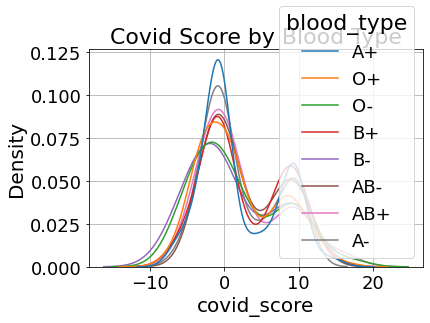

In [ ]:
#Plotting kde plot with raw blood_type feature
sns.kdeplot(data = train_df_clean, x = 'covid_score', hue = 'blood_type', common_norm = False).set_title('Covid Score by Blood Type')
plt.grid()

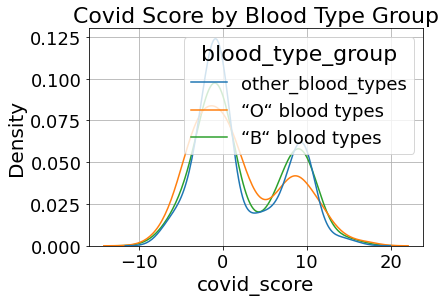

In [ ]:
#Adding temporary feature blood_type_group
def convert_to_groups(data):
  data.loc[data['A+'] == 1, 'blood_type_group'] = 'other_blood_types'
  data.loc[data['A-'] == 1, 'blood_type_group'] = 'other_blood_types'
  data.loc[data['B+'] == 1, 'blood_type_group'] = '“B“ blood types'
  data.loc[data['B-'] == 1, 'blood_type_group'] = '“B“ blood types'
  data.loc[data['O+'] == 1, 'blood_type_group'] = '“O“ blood types'
  data.loc[data['O-'] == 1, 'blood_type_group'] = '“O“ blood types'
  data.loc[data['AB+'] == 1, 'blood_type_group'] = '“B“ blood types'
  data.loc[data['AB-'] == 1, 'blood_type_group'] = '“B“ blood types'


#Plotting kde plot with blood type groups
convert_to_groups(train_df_clean)
sns.kdeplot(data = train_df_clean, x = 'covid_score', hue = 'blood_type_group', common_norm = False).set_title('Covid Score by Blood Type Group')
plt.grid()

###Q2

In [ ]:
#Dropping features and adding new OHE features
def convert_to_ohe(data):
  data.loc[data['blood_type_group'] == 'other_blood_types', 'other_blood_types'] = 1
  data.loc[data['blood_type_group'] != 'other_blood_types', 'other_blood_types'] = 0
  data.loc[data['blood_type_group'] == '“B“ blood types', '“B“ blood types'] = 1
  data.loc[data['blood_type_group'] != '“B“ blood types', '“B“ blood types'] = 0
  data.loc[data['blood_type_group'] == '“O“ blood types', '“O“ blood types'] = 1
  data.loc[data['blood_type_group'] != '“O“ blood types', '“O“ blood types'] = 0

convert_to_groups(test_df_clean)
convert_to_ohe(train_df_clean)
convert_to_ohe(test_df_clean)

columns_to_drop = ['blood_type', 'A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-', 'blood_type_group']
train_df_clean.drop(columns_to_drop, axis = 1, inplace = True)
test_df_clean.drop(columns_to_drop, axis = 1, inplace = True)

#Section 2: Linear regression implementation

##Q3

In [ ]:
#Splitting the data into 'train' and 'test'
training_subset_from_train, validation_subtest_from_train = train_test_split(train_df_clean, test_size = 0.2, train_size = 0.8, random_state = 122)

###LinearRegressor

In [ ]:
#Our implementation of a linear regressor
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        coeffs = (1/y.size)

        f = X.dot(w.reshape(-1,1))
        f = np.add(f, (np.ones(y.shape)*b).reshape(-1,1))
        f = np.subtract(f, np.array(y).reshape(-1,1))
        norm = np.linalg.norm(f)**2
        loss = coeffs * norm

        return loss


    @staticmethod
    def gradient(w, b: float, X, y):

  
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        f = np.add(X.dot(w.reshape(-1,1)), ((np.ones(y.shape)*b).reshape(-1,1)))
        f = np.subtract(f, np.array(y).reshape(-1,1))

        g_w = (2/y.size)*X.transpose()@f
        g_w = g_w.transpose()

        g_b = (2/y.size)*(np.ones(y.shape)).transpose()@f
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w.reshape(self.w.size,1) - self.lr * g_w.transpose()
            self.b = self.b - self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = (X.dot(self.w) + self.b)

        return y_pred

##Q4

In [ ]:
#The provided verify_gradients
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


In [ ]:
#compares the numerical gradients to the analytical ones.
X_train = training_subset_from_train.copy()
X_train = X_train.drop(columns=['covid_score', 'spread_score']).to_numpy()
y_train = training_subset_from_train.covid_score.to_numpy()

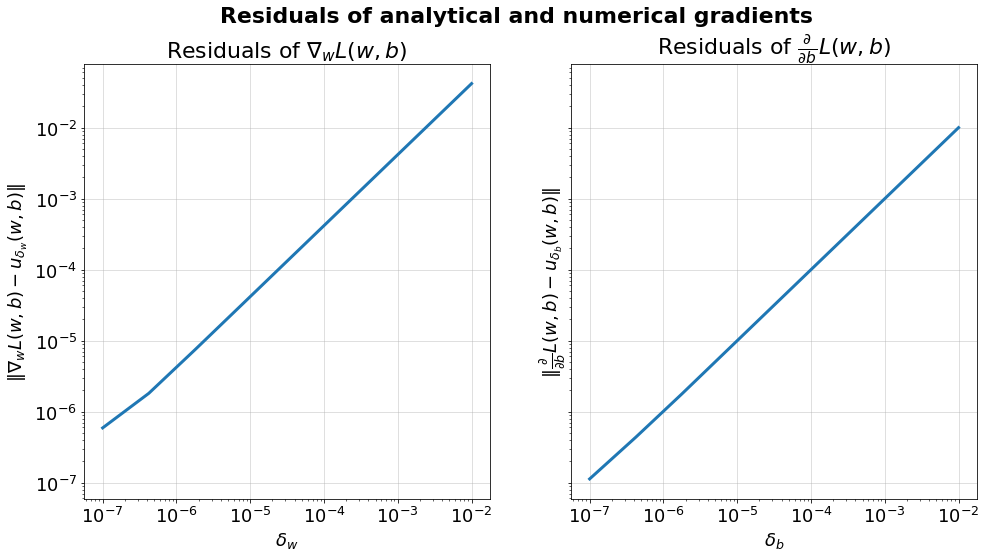

In [ ]:
compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

##Q5

In [ ]:
#The provided test_lr function
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

In [ ]:
#Creating validation datasets
X_val = validation_subtest_from_train.copy().drop(columns=['covid_score', 'spread_score']).to_numpy()
y_val = validation_subtest_from_train.covid_score.to_numpy()

lr size = 1e-09, Best train loss = 33.660118400584004, Best validation loss = 33.826952127487395
lr size = 1e-08, Best train loss = 33.65875274220821, Best validation loss = 33.82558501765262
lr size = 1e-07, Best train loss = 33.64510261608019, Best validation loss = 33.81192050662851
lr size = 1e-06, Best train loss = 33.50924349203369, Best validation loss = 33.675930470118296
lr size = 1e-05, Best train loss = 32.21143585844985, Best validation loss = 32.37807255730046
lr size = 0.0001, Best train loss = 23.163098603120176, Best validation loss = 23.415446494804854
lr size = 0.001, Best train loss = 7.048254508972466, Best validation loss = 7.830240725801368
lr size = 0.01, Best train loss = 3.2448590129222614, Best validation loss = 3.4697269831447426
lr size = 0.1, Best train loss = 3.1279633506741864, Best validation loss = 3.1632420270363504


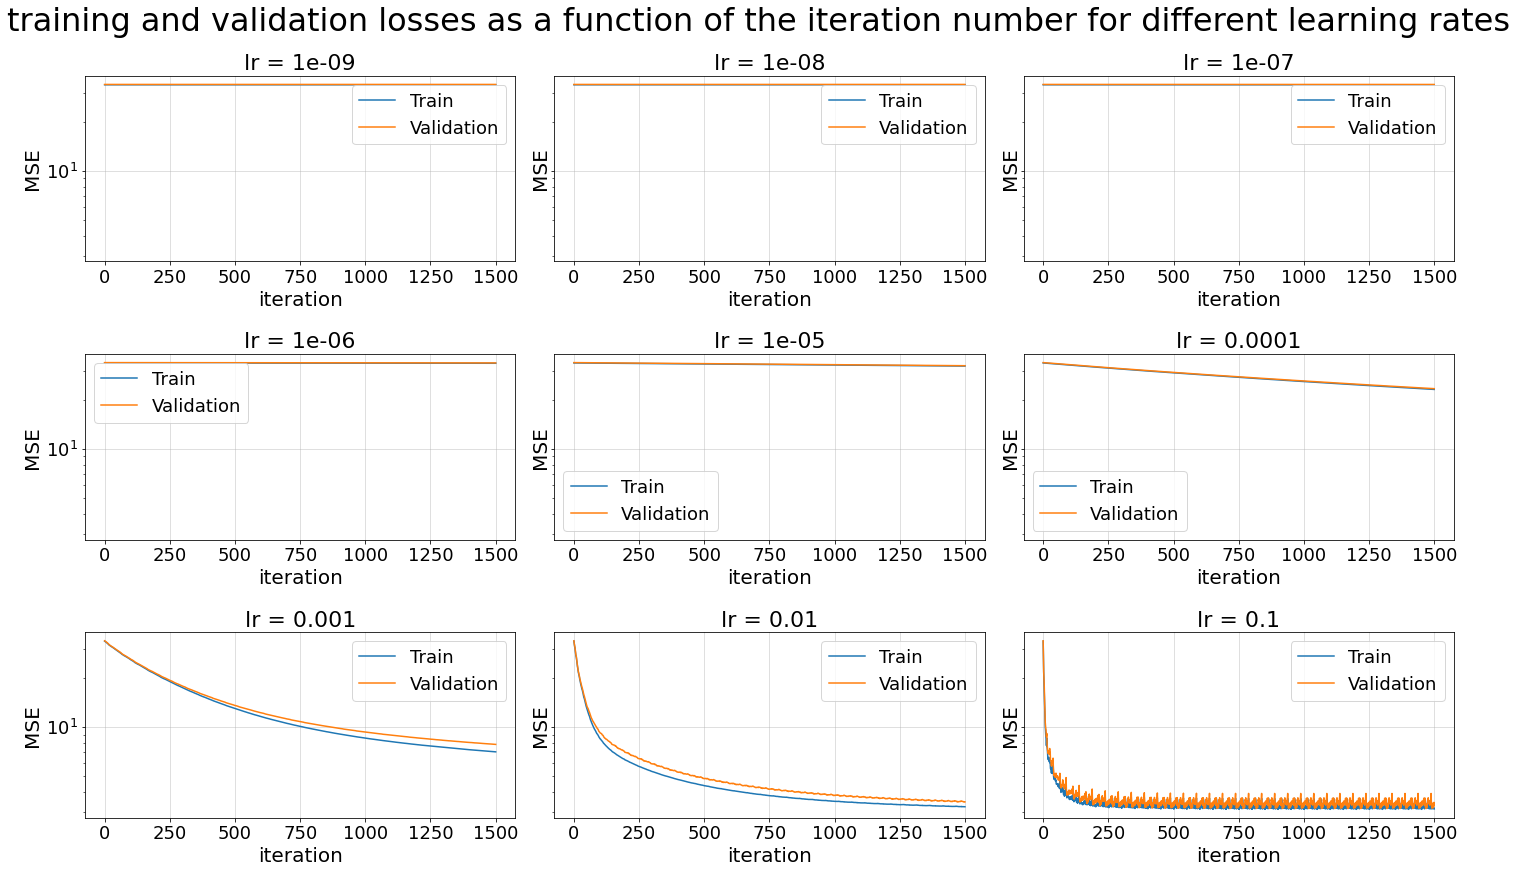

In [ ]:
test_lr(X_train, y_train, X_val, y_val, "training and validation losses as a function of the iteration number for different learning rates")

#Section 3: Evaluation and baseline

###Q6

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

#Creating and fitting the dummy regressor
dummy_regr = DummyRegressor(strategy="mean")
X = train_df_clean.copy()
X = X.drop(columns = ['covid_score', 'spread_score'])
y = train_df_clean.covid_score
X_np = X.to_numpy()
y_np = y.to_numpy()
cv_results = cross_validate(dummy_regr, X_np, y, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
dummy_valid_error = np.absolute(cv_results['test_score'].mean())
dummy_training_error = np.absolute(cv_results['train_score'].mean())
print("Mean train score is "+str(dummy_training_error)+" and mean validation score is "+str(dummy_valid_error))

Mean train score is 29.298227835023066 and mean validation score is 29.314528343197374


In [ ]:
#Retraining the dummy regressor
dummy_regr.fit(X_np,y_np)

DummyRegressor()

###Q7

best lr value is 0.04393970560760795 , its train accuracy is 3.1067806814422694and its validation accuracy is 3.173722881762955


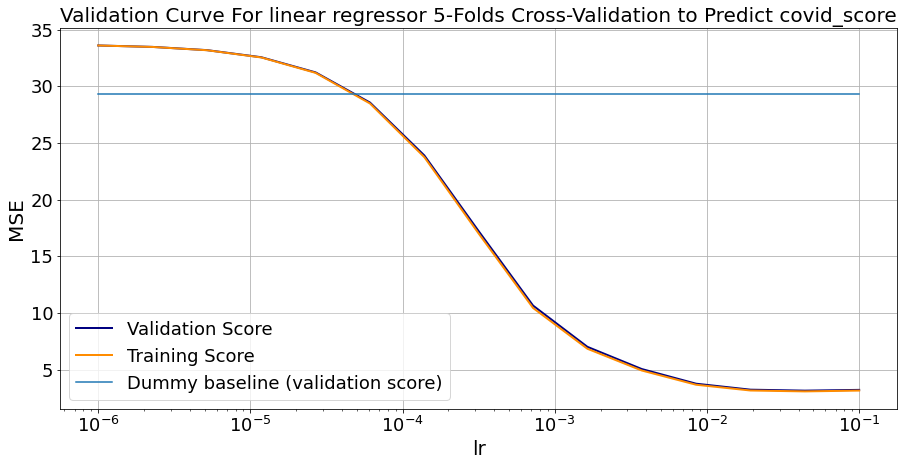

In [ ]:
#Creating dataframes and empty lists to store mean errors
lr_list = np.logspace(-6, -1, 15)
validation_scores_mean = []
train_scores_mean = []
dummy_error = []


#Performing cross validation with k = 5
for lr in lr_list:
  linear_regr = LinearRegressor(lr)
  cv = cross_validate(linear_regr, X_np, y_np, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  validation_scores_mean.append(np.absolute(np.mean(cv['test_score'])))
  train_scores_mean.append(np.absolute(np.mean(cv['train_score'])))
  dummy_error.append(dummy_valid_error)

#Plotting the validation curve
plt.figure(figsize=(15, 7))
plt.semilogx(lr_list, validation_scores_mean, label="Validation Score", color="navy", lw=2)
plt.semilogx(lr_list, train_scores_mean, label="Training Score", color="darkorange", lw=2)
plt.plot(lr_list, dummy_error, label='Dummy baseline (validation score)')
plt.legend()
plt.grid(visible = True)
plt.xlabel("lr")
plt.ylabel("MSE")
plt.title("Validation Curve For linear regressor 5-Folds Cross-Validation to Predict covid_score", fontsize = 20)

best_validation_accuracy = np.min(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_lr = lr_list[best_validation_accuracy_index]
print("best lr value is "+str(best_lr)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))

###Q8

In [ ]:
#Retraining our linear regressor with the optimal learning rate
linear_regressor = LinearRegressor(best_lr)
linear_regressor.fit(X_np,y_np)

LinearRegressor(lr=0.04393970560760795)

#Section 4: Ridge linear regression

###Q9

best alpha value is 0.5108969774506924 , its train accuracy is 3.0357396022075513and its validation accuracy is 3.1004276330083176


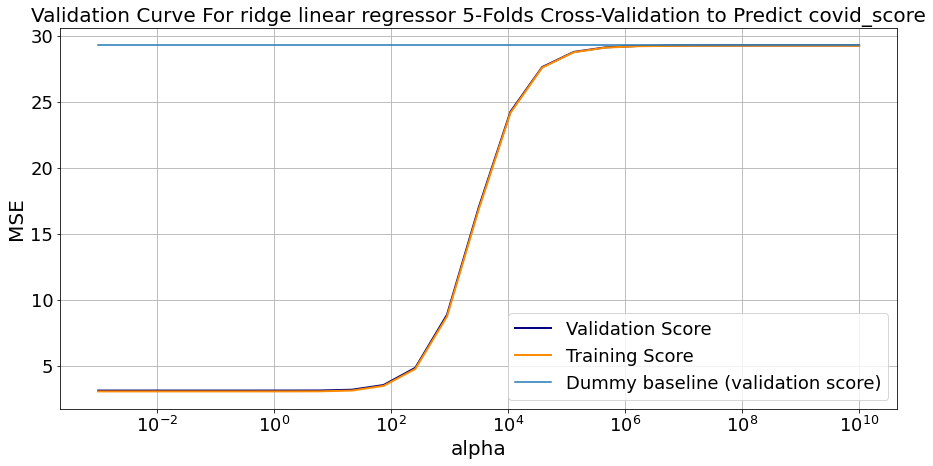

In [ ]:
from sklearn.linear_model import Ridge

#Creating dataframes and empty lists to store mean errors
alpha_list = np.logspace(-3, 10, 25)
validation_scores_mean = []
train_scores_mean = []
dummy_error = []


#Performing cross validation with k = 5
for alpha in alpha_list:
  ridge_inst = Ridge(alpha, fit_intercept=True)
  cv = cross_validate(ridge_inst, X_np, y_np, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  validation_scores_mean.append(np.absolute(np.mean(cv['test_score'])))
  train_scores_mean.append(np.absolute(np.mean(cv['train_score'])))
  dummy_error.append(dummy_valid_error)

#Plotting the validation curve
plt.figure(figsize=(15, 7))
plt.semilogx(alpha_list, validation_scores_mean, label="Validation Score", color="navy", lw=2)
plt.semilogx(alpha_list, train_scores_mean, label="Training Score", color="darkorange", lw=2)
plt.plot(alpha_list, dummy_error, label='Dummy baseline (validation score)')
plt.legend()
plt.grid(visible = True)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("Validation Curve For ridge linear regressor 5-Folds Cross-Validation to Predict covid_score", fontsize = 20)

best_validation_accuracy = np.min(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_alpha_covid = alpha_list[best_validation_accuracy_index]
print("best alpha value is "+str(best_alpha_covid)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))


In [ ]:
#Retraining our ridge linear regressor with the optimal alpha
ridge_linear_regressor = Ridge(best_alpha_covid, fit_intercept=True)
ridge_linear_regressor.fit(X_np,y_np)

Ridge(alpha=0.5108969774506924)

###Q11

In [ ]:
#Finding 5 features with largest coefficients
print(ridge_linear_regressor.coef_)
print(X.columns)

[-1.79429369e-02  3.21352362e-02 -5.44027321e+00  7.97448339e-01
 -1.00908605e-02  1.49416188e-01  6.90566118e-03 -3.34349297e-02
  1.89359321e-02 -2.08927994e-01 -2.49447634e-03  4.04572071e-01
  5.80282902e-02  7.39471594e-02  2.26963474e+00  4.91997389e+00
  1.54525429e-02  5.55293181e-02 -1.90828108e-01 -5.09501199e-02
 -1.59004555e-01]
Index(['sex', 'sugar_levels', 'sport_activity', 'PCR_01', 'PCR_02', 'PCR_04',
       'PCR_05', 'PCR_06', 'PCR_08', 'PCR_09', 'PCR_10', 'cough', 'fever',
       'low_appetite', 'shortness_of_breath', 'sore_throat', 'pcr_month',
       'pcr_year', 'other_blood_types', '“B“ blood types', '“O“ blood types'],
      dtype='object')


Text(0, 0.5, 'absolute value')

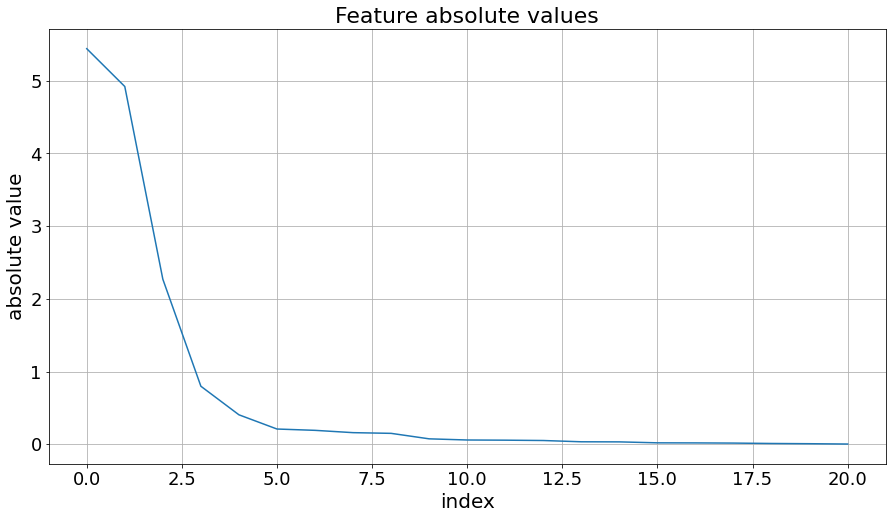

In [ ]:
#Plotting absolute value of coefficients by descending order
sorted_coefs = list(np.sort(np.absolute(ridge_linear_regressor.coef_))[::-1])
index = [i for i in range(ridge_linear_regressor.coef_.size)]
plt.figure(figsize=(15, 8))
plt.plot(index, sorted_coefs)
plt.grid(visible = True)
plt.title("Feature absolute values")
plt.xlabel("index")
plt.ylabel("absolute value")

#Section 5: Polynomial fitting (visualization)

In [ ]:
#Creating temporary dataframes
train_subset = train_df_clean.copy()
train_subset = train_subset[['sugar_levels', 'PCR_05', 'spread_score']]

In [ ]:
#The provided plot3d function
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

###Q15

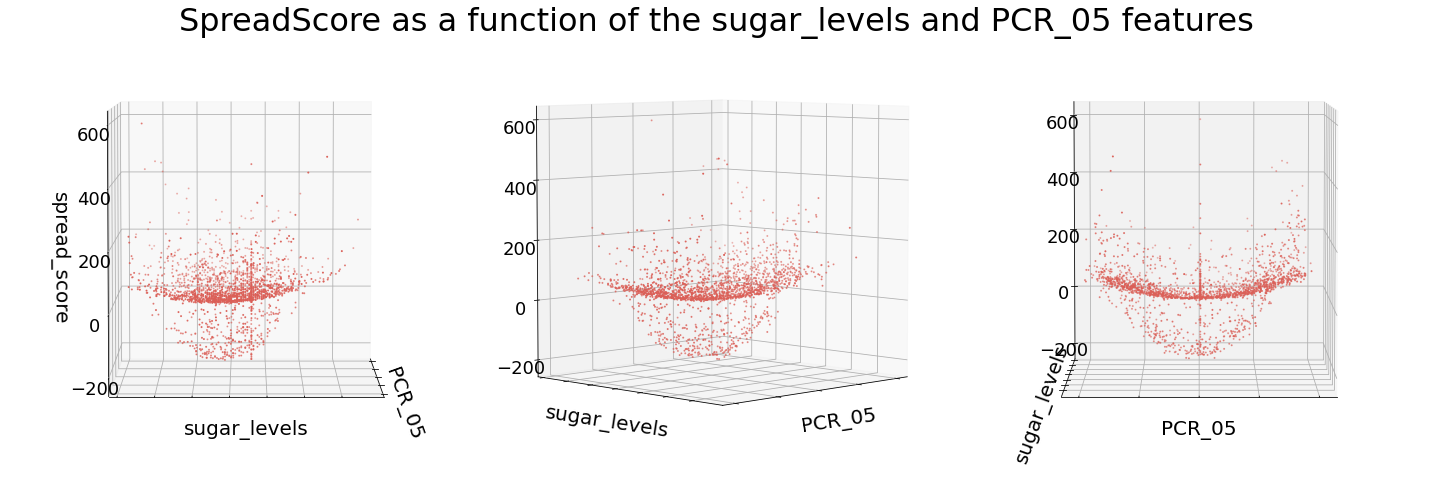

In [ ]:
plot3d(train_subset,'PCR_05','sugar_levels', 'spread_score', 'SpreadScore as a function of the sugar_levels and PCR_05 features' )

###Q16

best alpha value is 261.0157215682533 , its train accuracy is 7246.830066714206and its validation accuracy is 7291.504310386832


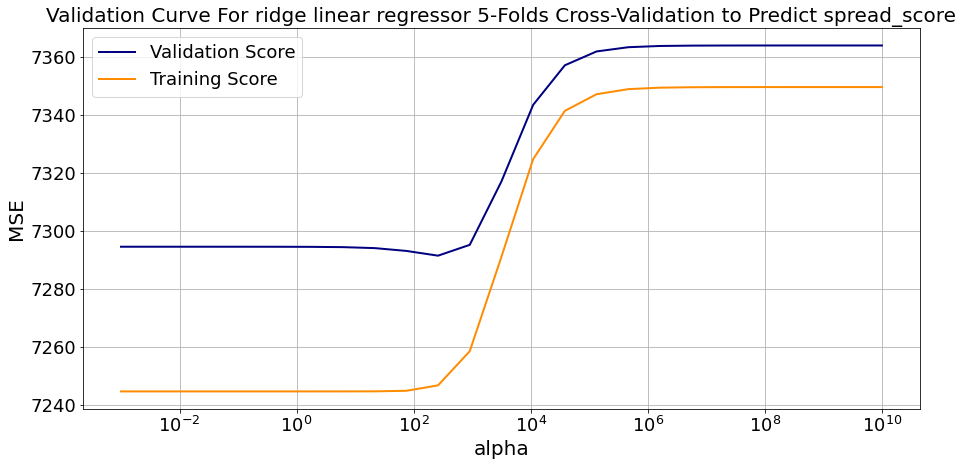

In [ ]:
#Creating dataframes and empty lists to store mean errors
alpha_list = np.logspace(-3, 10, 25)
validation_scores_mean = []
train_scores_mean = []
X = train_subset.drop(columns=['spread_score']).to_numpy()
y = train_subset.spread_score.to_numpy()

#Performing cross validation with k = 5
for alpha in alpha_list:
  ridge_inst = Ridge(alpha, fit_intercept=True)
  cv = cross_validate(ridge_inst, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  validation_scores_mean.append(np.absolute(np.mean(cv['test_score'])))
  train_scores_mean.append(np.absolute(np.mean(cv['train_score'])))

#Plotting the validation curve
plt.figure(figsize=(15, 7))
plt.semilogx(alpha_list, validation_scores_mean, label="Validation Score", color="navy", lw=2)
plt.semilogx(alpha_list, train_scores_mean, label="Training Score", color="darkorange", lw=2)
plt.legend()
plt.grid(visible = True)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("Validation Curve For ridge linear regressor 5-Folds Cross-Validation to Predict spread_score", fontsize = 20)

best_validation_accuracy = np.min(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_alpha_spread = alpha_list[best_validation_accuracy_index]
print("best alpha value is "+str(best_alpha_spread)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))

In [ ]:
#Retraining the ridge regressor with the optimal alpha
ridge_linear_regressor = Ridge(best_alpha_spread, fit_intercept=True)
ridge_linear_regressor.fit(X,y)

Ridge(alpha=261.0157215682533)

##Q17

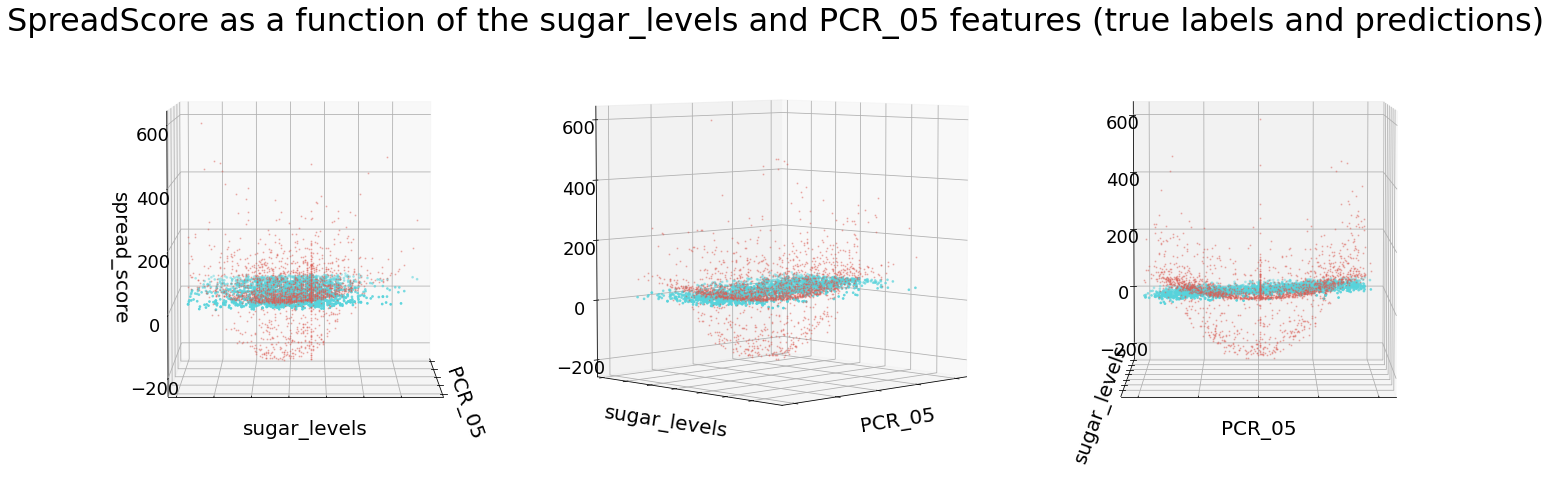

In [ ]:
#Plotting the true labels and the predictions of the model
plot3d(train_subset,'PCR_05','sugar_levels', 'spread_score', 'SpreadScore as a function of the sugar_levels and PCR_05 features (true labels and predictions)', predictions=ridge_linear_regressor.predict(X))

###Q19

In [ ]:
#A single model that: (1) transforms the original features into 2nd-degree polynomial features, (2) normalizes the transformed features, and then (3) trains the linear Ridge regressor on these normalized polynomial features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
pipe_inst = Pipeline([('feature_mapping', PolynomialFeatures(2)), ('normalization', StandardScaler()),('Ridge', Ridge(fit_intercept=True))])


In [ ]:
X = train_df_clean.copy()
X = X[['sugar_levels', 'PCR_05', 'spread_score']]
baseline_validation = best_validation_accuracy

best Lambda value is 13.33521432163324 , its train accuracy is 4496.622960359483and its validation accuracy is 4567.879981475209


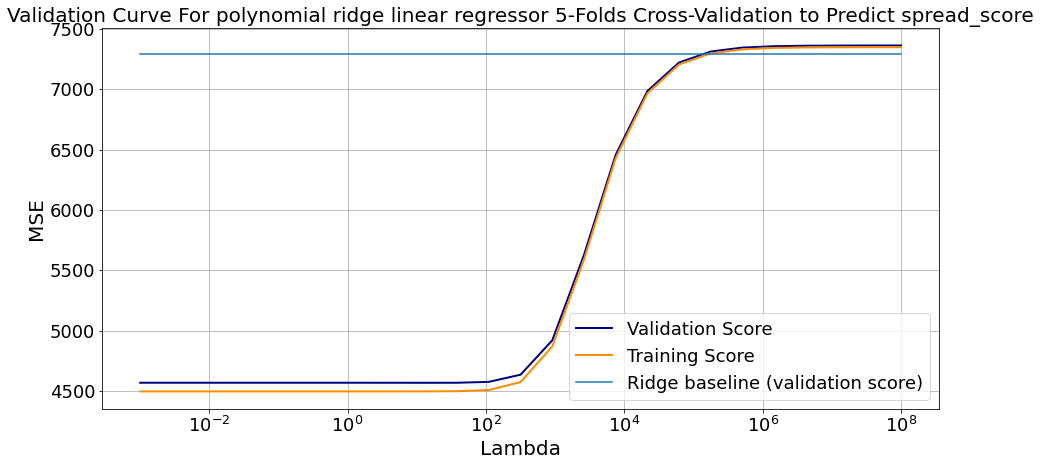

In [ ]:
#Creating dataframes and empty lists to store mean errors
Lambda_list = np.logspace(-3, 8, 25)
validation_scores_mean = []
train_scores_mean = []
baseline_error = []

X_np = X.drop(columns=['spread_score']).to_numpy()
y_np = X.spread_score.to_numpy()


#Performing cross validation with k = 5
for Lambda in Lambda_list:
  poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(2)), ('normalization', StandardScaler()),('Ridge', Ridge(alpha=Lambda, fit_intercept=True))])
  cv = cross_validate(poly_reg, X_np, y_np, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  validation_scores_mean.append(np.absolute(np.mean(cv['test_score'])))
  train_scores_mean.append(np.absolute(np.mean(cv['train_score'])))
  baseline_error.append(baseline_validation)

#Plotting the validation curve
plt.figure(figsize=(15, 7))
plt.semilogx(Lambda_list, validation_scores_mean, label="Validation Score", color="navy", lw=2)
plt.semilogx(Lambda_list, train_scores_mean, label="Training Score", color="darkorange", lw=2)
plt.plot(Lambda_list, baseline_error, label='Ridge baseline (validation score)')
plt.legend()
plt.grid(visible = True)
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("Validation Curve For polynomial ridge linear regressor 5-Folds Cross-Validation to Predict spread_score", fontsize = 20)

best_validation_accuracy = np.min(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_lambda_spread = Lambda_list[best_validation_accuracy_index]
print("best Lambda value is "+str(best_lambda_spread)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))

In [ ]:
#Retraining our pipeline ridge linear regressor with the optimal alpha

polynomial_ridge_spread = Pipeline([('feature_mapping', PolynomialFeatures(2)),
               ('normalization', StandardScaler()),
               ('Ridge', Ridge(alpha=best_lambda_spread, fit_intercept=True))])
polynomial_ridge_spread.fit(X_np, y_np)

Pipeline(steps=[('feature_mapping', PolynomialFeatures()),
                ('normalization', StandardScaler()),
                ('Ridge', Ridge(alpha=13.33521432163324))])

##Q20

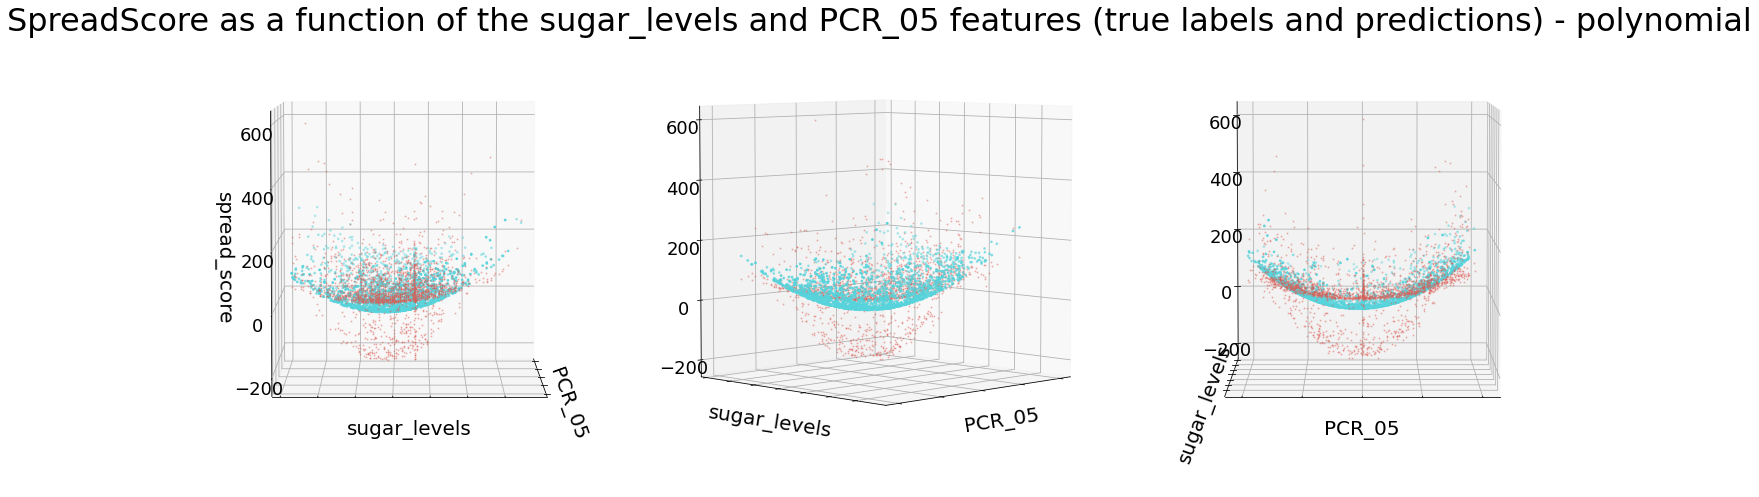

In [ ]:
#Plotting the true labels and the predictions of the model
plot3d(train_subset,'PCR_05','sugar_levels', 'spread_score', 'SpreadScore as a function of the sugar_levels and PCR_05 features (true labels and predictions) - polynomial', predictions=polynomial_ridge_spread.predict(X_np))

#Section 6: Polynomial fitting of the CovidScore

In [ ]:
#Creating temporary data frames, an instance of the pipeline with all features
from sklearn.preprocessing import MinMaxScaler

train_copy = train_df_clean.copy().drop(columns = ['spread_score'])
test_copy = test_df_clean.copy().drop(columns = ['spread_score'])
pipeline_inst = Pipeline([('feature_mapping', PolynomialFeatures(2)), ('normalization', MinMaxScaler()),('Ridge', Ridge(alpha=Lambda, fit_intercept=True))])


###Q25

best Lambda value is 0.01 , its train accuracy is 0.00034394631701169573and its validation accuracy is 0.0013385367854272612


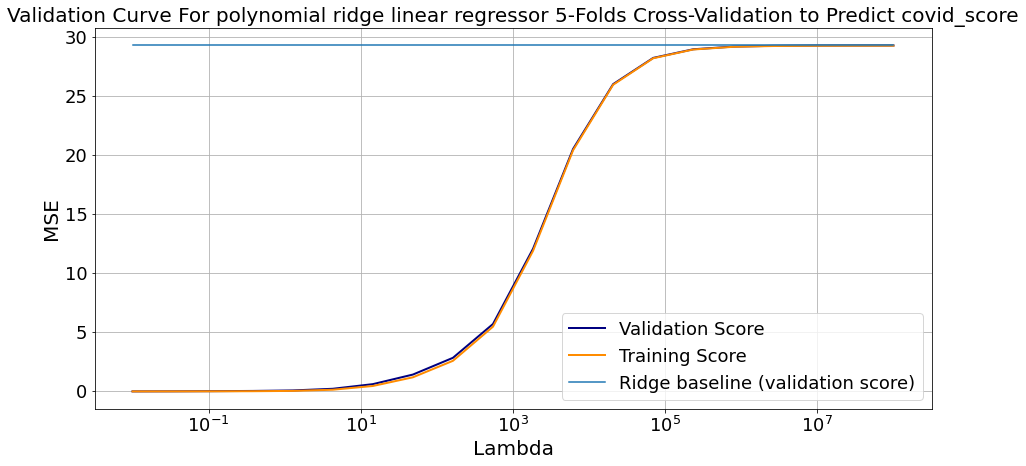

In [ ]:
#Creating dataframes and empty lists to store mean errors
Lambda_list = np.logspace(-2, 8, 20)
validation_scores_mean = []
train_scores_mean = []
dummy_error = []

X_np = train_copy.to_numpy()
y_np = train_copy.covid_score.to_numpy()


#Performing cross validation with k = 5
for Lambda in Lambda_list:
  poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(2)), ('normalization', MinMaxScaler()),('Ridge', Ridge(alpha=Lambda, fit_intercept=True))])
  cv = cross_validate(poly_reg, X_np, y_np, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  validation_scores_mean.append(np.absolute(np.mean(cv['test_score'])))
  train_scores_mean.append(np.absolute(np.mean(cv['train_score'])))
  dummy_error.append(dummy_valid_error)

#Plotting the validation curve
plt.figure(figsize=(15, 7))
plt.semilogx(Lambda_list, validation_scores_mean, label="Validation Score", color="navy", lw=2)
plt.semilogx(Lambda_list, train_scores_mean, label="Training Score", color="darkorange", lw=2)
plt.plot(Lambda_list, dummy_error, label='Ridge baseline (validation score)')
plt.legend()
plt.grid(visible = True)
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("Validation Curve For polynomial ridge linear regressor 5-Folds Cross-Validation to Predict covid_score", fontsize = 20)

best_validation_accuracy = np.min(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_lambda_covid = Lambda_list[best_validation_accuracy_index]
print("best Lambda value is "+str(best_lambda_covid)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))

In [ ]:
#Retraining our pipeline ridge linear regressor with the optimal alpha
polynomial_ridge_covid = Pipeline([('feature_mapping', PolynomialFeatures(2)),
               ('normalization', StandardScaler()),
               ('Ridge', Ridge(alpha=best_lambda_covid, fit_intercept=True))])
polynomial_ridge_covid.fit(X_np, y_np)

Pipeline(steps=[('feature_mapping', PolynomialFeatures()),
                ('normalization', StandardScaler()),
                ('Ridge', Ridge(alpha=0.01))])

#Section 7: Testing your models

In [ ]:
#Creating dataframes
test_features = test_df_clean.drop(columns = ['spread_score', 'covid_score']).to_numpy()
test_label = test_df_clean.covid_score.to_numpy()
train_features = train_df_clean.drop(columns = ['spread_score', 'covid_score']).to_numpy()
train_label = train_df_clean.covid_score.to_numpy()

In [ ]:
#Using all our trained models to predict test labels. We also calculate the accuracy score for each model

from sklearn.metrics import mean_squared_error
#Dummy regressor
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(train_features, train_label)

print("Accuracy score for dummy regressor is "+str(dummy_regressor.score(test_features, test_label)))
print("MSE for dummy regressor is "+str(mean_squared_error(dummy_regressor.predict(test_features), test_label)))

Accuracy score for dummy regressor is -0.008982309944879585
MSE for dummy regressor is 30.595321292143414


In [ ]:
#Linear regressor
linear_regressor = LinearRegressor(best_lr)
linear_regressor.fit(train_features, train_label)

print("Accuracy score for linear regressor is "+str(linear_regressor.score(test_features, test_label)))
print("MSE for linear regressor is "+str(mean_squared_error(linear_regressor.predict(test_features), test_label)))

Accuracy score for linear regressor is 0.8714379857767958
MSE for linear regressor is 3.8983796765861305


In [ ]:
#Ridge linear regressor
ridge_linear_regressor = Ridge(best_alpha_covid, fit_intercept=True)
ridge_linear_regressor.fit(train_features, train_label)

print("Accuracy score for ridge linear regressor is "+str(ridge_linear_regressor.score(test_features, test_label)))
print("MSE for ridge linear regressor is "+str(mean_squared_error(ridge_linear_regressor.predict(test_features), test_label)))

Accuracy score for ridge linear regressor is 0.8738299624243497
MSE for ridge linear regressor is 3.8258478855587765


In [ ]:
#Ridge linear regressor with polynomial mapping
polynomial_ridge_covid = Pipeline([('feature_mapping', PolynomialFeatures(2)),
               ('normalization', StandardScaler()),
               ('Ridge', Ridge(alpha=best_lambda_covid, fit_intercept=True))])
polynomial_ridge_covid.fit(train_features, train_label)

print("Accuracy score for polynomial ridge linear regressor is "+str(polynomial_ridge_covid.score(test_features, test_label)))
print("MSE for polynomial ridge linear regressor is "+str(mean_squared_error(polynomial_ridge_covid.predict(test_features), test_label)))

Accuracy score for polynomial ridge linear regressor is 0.9082903125978978
MSE for polynomial ridge linear regressor is 2.780908370754924


# How to download from Colab?

In [ ]:
from google.colab import files
outputPath = "saved_file.csv"
dataset.to_csv(outputPath)
files.download(outputPath) 